In [43]:
import pickle
import tools.config as config
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.image as mpimg
from matplotlib.figure import Figure
from PIL import Image
import numpy as np

In [6]:
def load_figure_properly(base_path):
    """正确加载matplotlib图形"""
    pkl_path = f"{base_path}.pkl"
    
    if not os.path.exists(pkl_path):
        raise FileNotFoundError(f"Figure file not found: {pkl_path}")
    
    current_backend = matplotlib.get_backend()
    
    with open(pkl_path, "rb") as f:
        fig = pickle.load(f)
    # 重新激活图形
    fig.canvas.draw_idle()
    # 确保图形是当前活跃的
    plt.figure(fig.number)
    return fig

In [7]:
def add_north_arrow(fig, x, y, size=0.01, img_path='../Map/north_arrow.png', transform_type='figure'):
    """
    在图上添加自定义指北针图像

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
    x, y : float           # 左下角位置 (0-1)
    size : float           # 指北针相对于画布的宽度 (0-1)
    img_path : str         # 图片路径
    transform_type : str   # 'figure' 或 'axes'
    """
    img = mpimg.imread(img_path)

    if transform_type == 'figure':
        ax_img = fig.add_axes([x, y, size, size * img.shape[0] / img.shape[1]])  # 保持宽高比
    else:
        # 如果你想在某个ax的坐标系统内放，可以用 ax.inset_axes
        raise NotImplementedError("当前示例只做 figure 坐标系")

    ax_img.imshow(img)
    ax_img.axis('off')  # 不显示坐标轴

In [44]:
def adjust_figure_layout(
    old_fig: Figure, 
    left: float = 0.05, 
    right: float = 0.95, 
    bottom: float = 0.05, 
    top: float = 0.95, 
    wspace: float = 0.1, 
    hspace: float = 0.1
) -> Figure:
    """
    调整一个已有图形的内部间距和外部边距，并自动裁剪多余空白。
    """
    
    # --- 第一步: 在 old_fig 上调整内部间距 (wspace, hspace) ---
    # (这部分代码与之前相同，保持不变)
    axes_list = old_fig.axes
    if axes_list:
        rows, cols = set(), set()
        for ax in axes_list:
            try:
                ss = ax.get_subplotspec()
                rows.update(range(ss.rowspan.start, ss.rowspan.stop))
                cols.update(range(ss.colspan.start, ss.colspan.stop))
            except AttributeError: continue
        
        if rows and cols:
            num_rows, num_cols = len(rows), len(cols)
            total_plot_width, total_plot_height = 1.0, 1.0
            cell_width = total_plot_width / (num_cols + wspace * (num_cols - 1))
            cell_height = total_plot_height / (num_rows + hspace * (num_rows - 1))
            ax_width, ax_height = cell_width, cell_height
            w_gap, h_gap = cell_width * wspace, cell_height * hspace

            for ax in axes_list:
                try:
                    ss = ax.get_subplotspec()
                    col_start, row_start = ss.colspan.start, ss.rowspan.start
                    new_x0 = col_start * (ax_width + w_gap)
                    new_y0 = (num_rows - 1 - row_start) * (ax_height + h_gap)
                    ax.set_position([new_x0, new_y0, ax_width, ax_height])
                except AttributeError: continue
            print("步骤1: 已在内存中调整内部间距。")

    # --- 新增步骤: 渲染并自动裁剪 ---
    old_fig.canvas.draw()
    # 将渲染结果转为 numpy 数组 (Height, Width, 4-channels RGBA)
    image_rgba = np.array(old_fig.canvas.buffer_rgba())
    
    # 从 RGBA 的 Alpha 通道找到非完全透明的区域
    alpha_channel = image_rgba[:, :, 3]
    solid_pixels = np.where(alpha_channel > 0) # 找到所有不透明像素的坐标
    
    if solid_pixels[0].size == 0:
         # 如果图片完全透明，不做处理
        cropped_image_data = image_rgba
        print("警告：渲染的图形是完全透明的。")
    else:
        # 计算内容区的边界框 (top, bottom, left, right)
        top_bound = np.min(solid_pixels[0])
        bottom_bound = np.max(solid_pixels[0])
        left_bound = np.min(solid_pixels[1])
        right_bound = np.max(solid_pixels[1])
        
        # 根据边界框裁剪图像
        cropped_image_data = image_rgba[top_bound:bottom_bound+1, left_bound:right_bound+1, :]
        print("步骤2: 已自动裁剪渲染图形的空白区域。")

    # --- 第三步: 将裁剪后的图像嵌入带外部边距的新图中 ---
    new_fig = plt.figure(figsize=old_fig.get_size_inches())
    width = right - left
    height = top - bottom
    if width <= 0 or height <= 0:
        raise ValueError("边距参数无效 (e.g., left >= right)。请检查参数。")
    rect = [left, bottom, width, height]
    ax_container = new_fig.add_axes(rect)

    # 显示裁剪后的图像
    ax_container.imshow(cropped_image_data)
    ax_container.axis('off')
    
    print("步骤3: 已成功将裁剪后的图形嵌入到指定边距的新画布中。")

    return new_fig

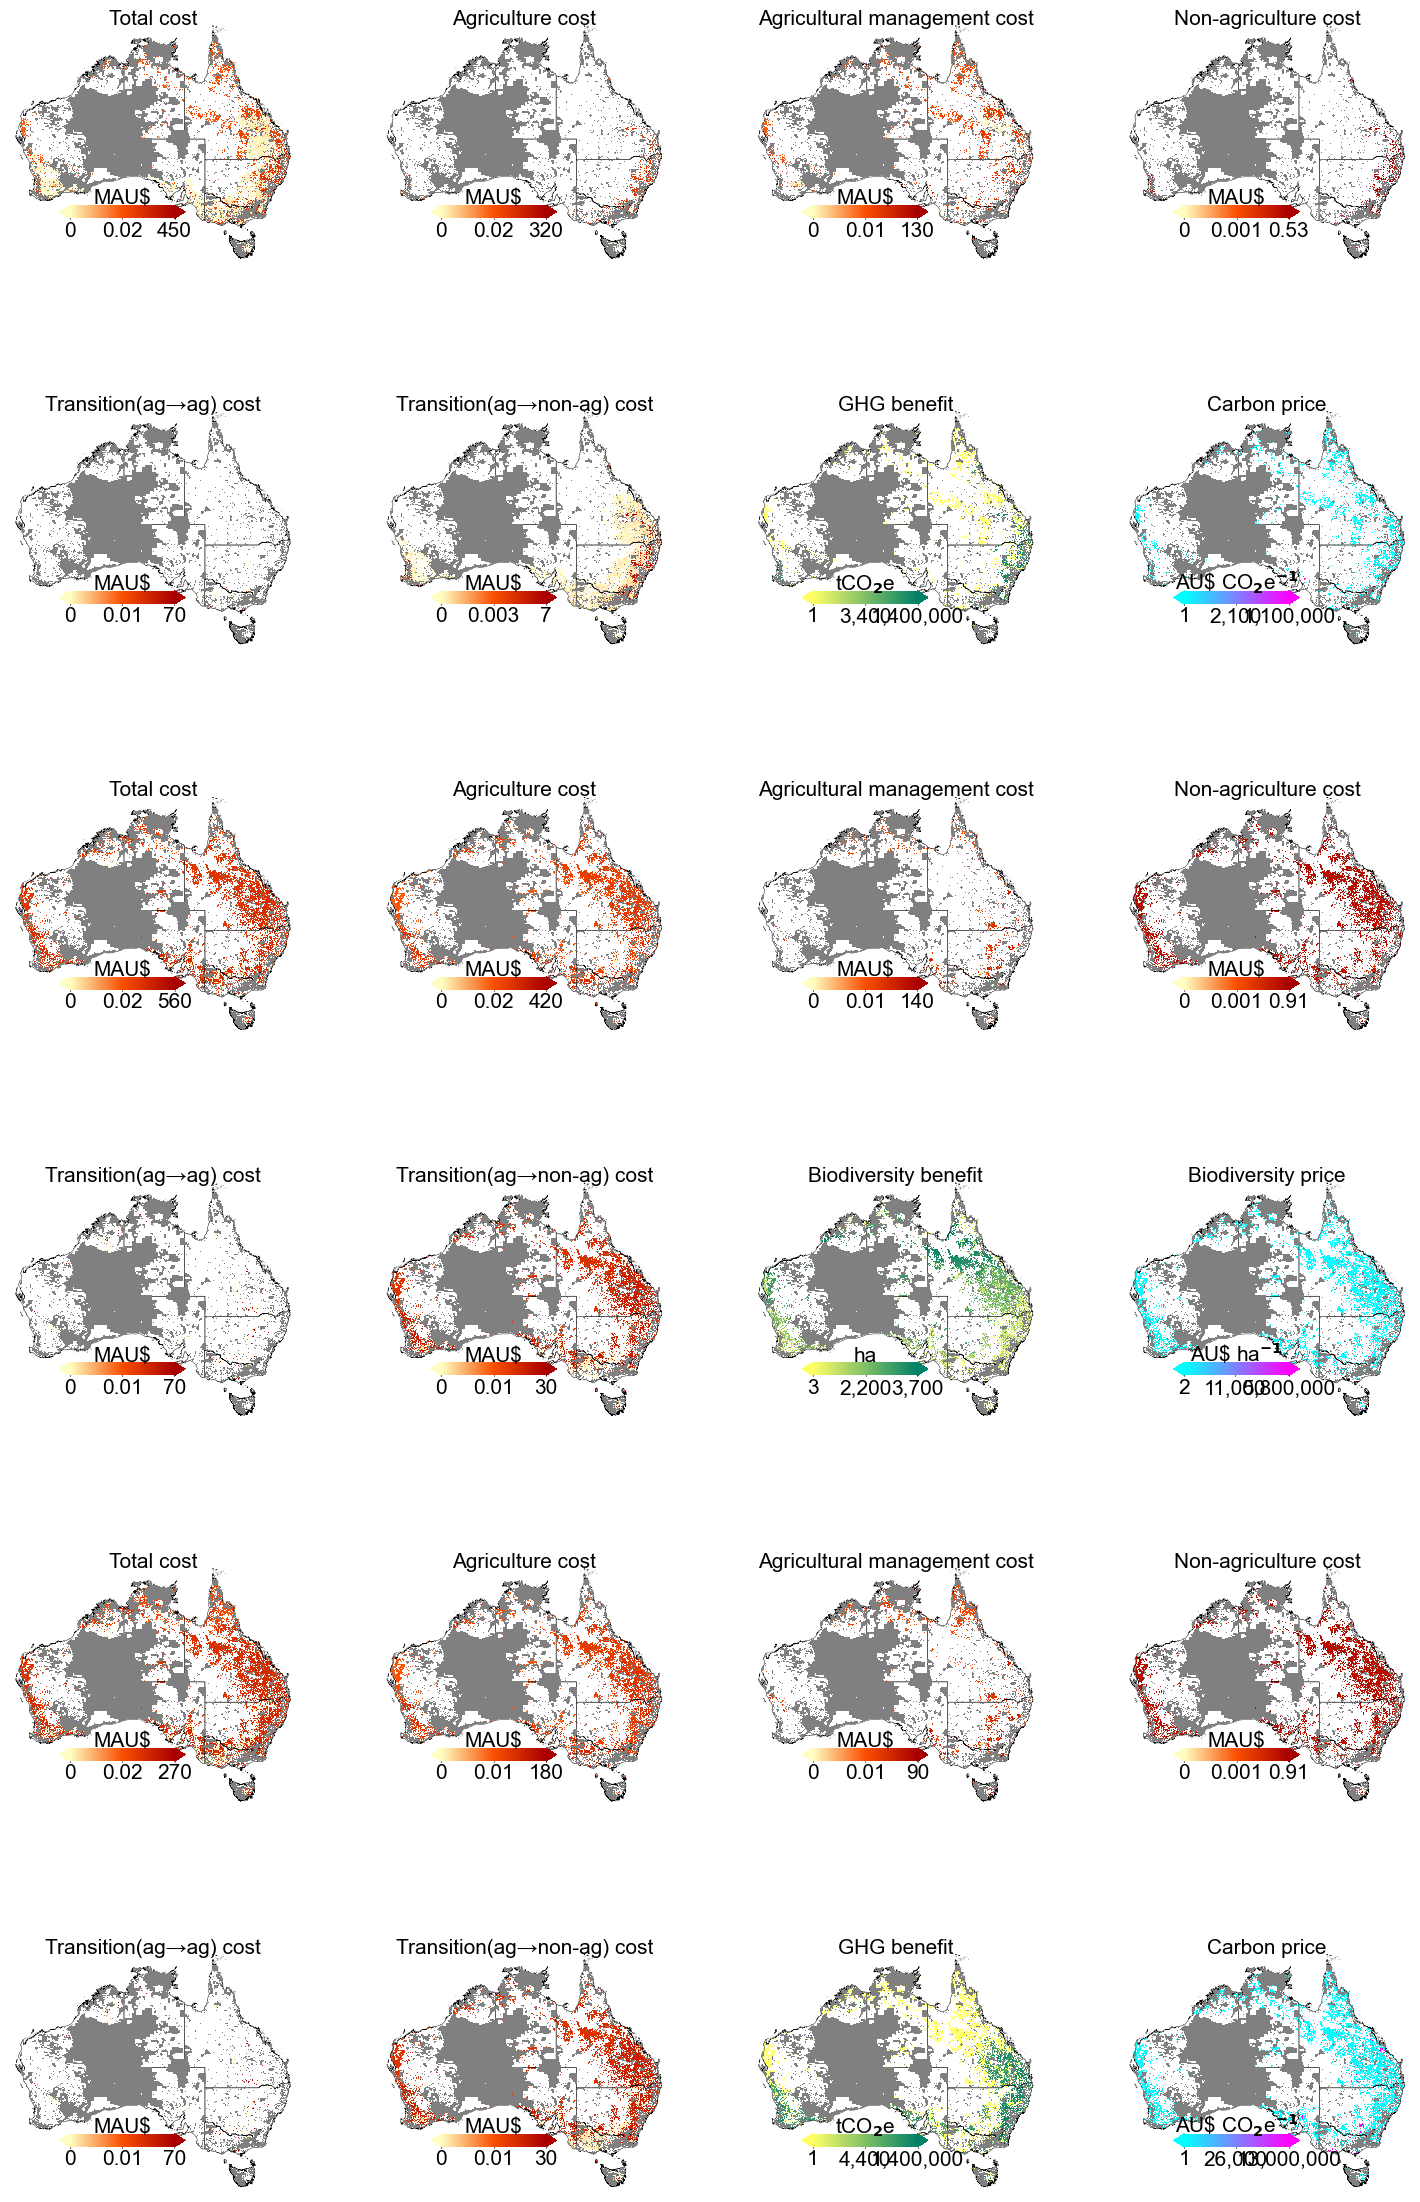

In [45]:
base_dir = f"../../../output/{config.TASK_NAME}/carbon_price"
arr_path = f"{base_dir}/4_tif"
out_dir  = f"{base_dir}/5_map"
pkl_path = f"{out_dir}/06_all_maps"
old_fig = load_figure_properly(pkl_path)

步骤1: 已在内存中调整内部间距。
步骤2: 已自动裁剪渲染图形的空白区域。
步骤3: 已成功将裁剪后的图形嵌入到指定边距的新画布中。


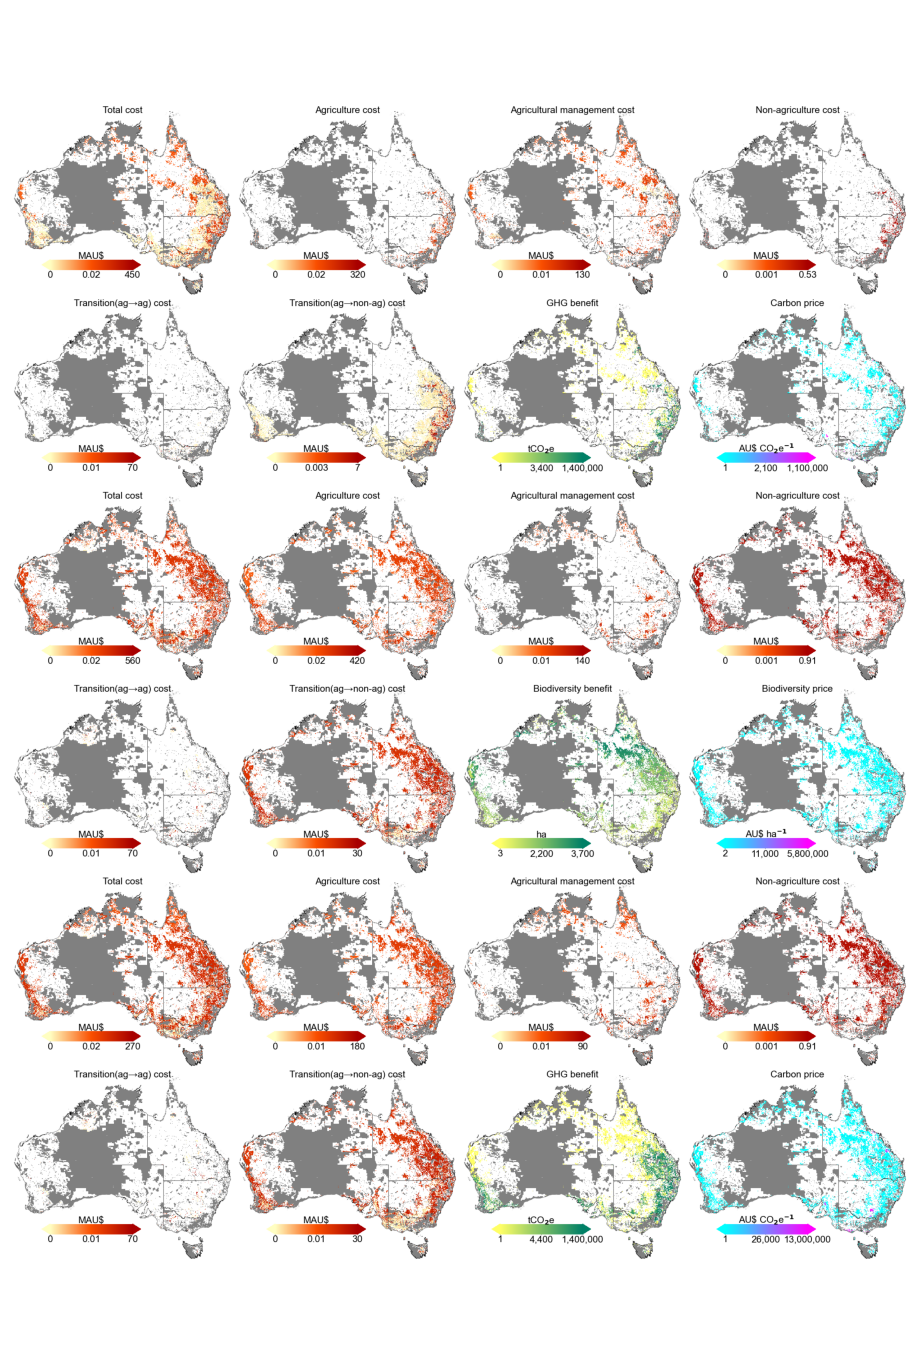

In [46]:
old_fig.set_constrained_layout(False)
new_fig = adjust_figure_layout(old_fig, 
                                 left=0.5,     # 左边距
                                 right=0.98,    # 右边距
                                 bottom=0.5,    # 底边距
                                 top=0.95,      # 顶边距
                                 wspace=0,  # 子图水平间距
                                 hspace=-0.5)      # 子图垂直间距

In [34]:
add_north_arrow(new_fig, 0.35,0.51,0.01)

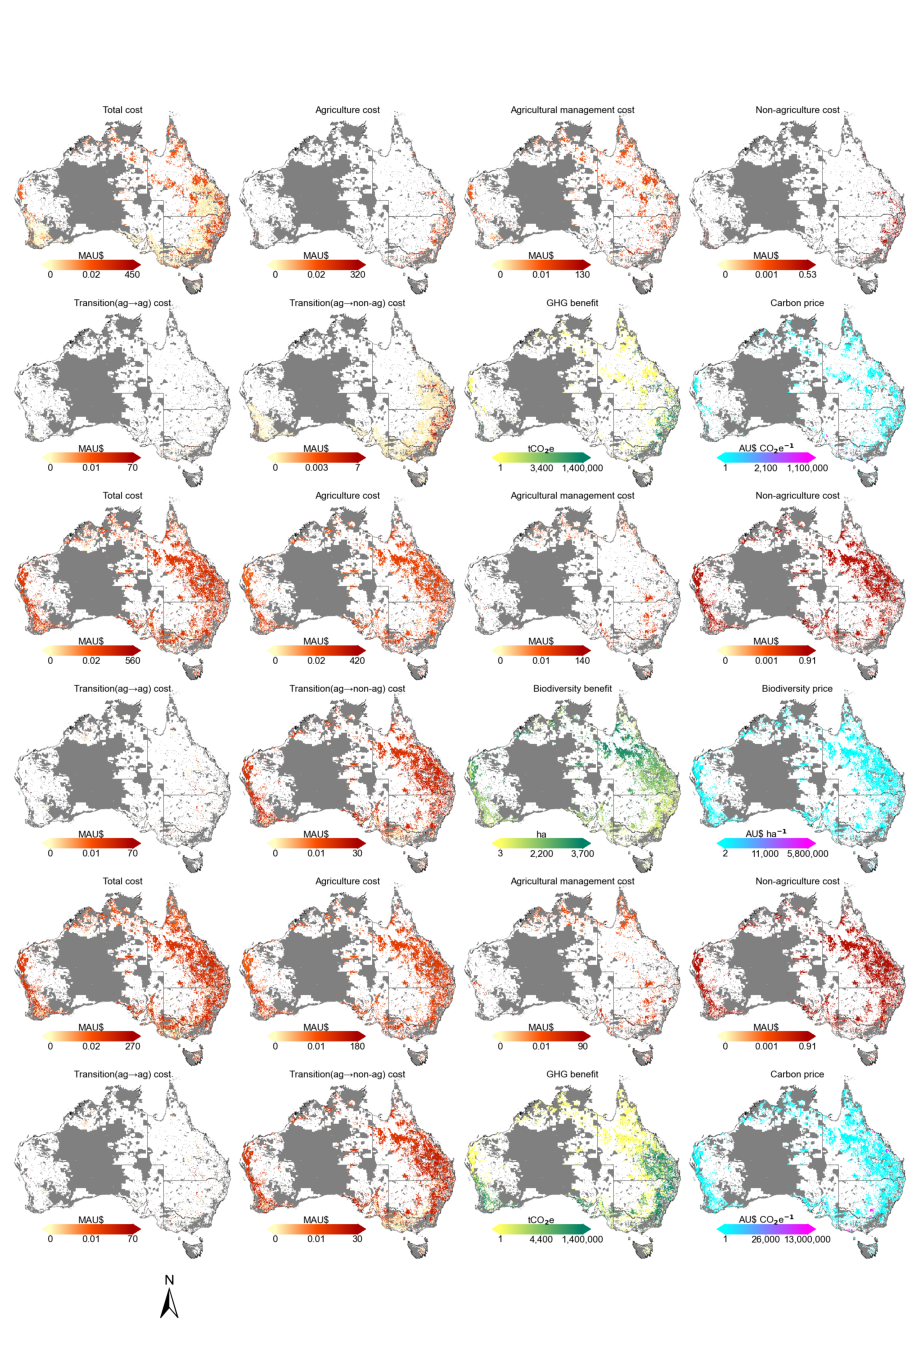

In [35]:
new_fig